In [1]:
infile1 = "/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalMisc/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historicalMisc_r1i1p1_185001-185912.nc"
infile2 = "/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalMisc/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historicalMisc_r1i1p1_186001-186912.nc"
allfiles = "/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalMisc/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historicalMisc_r1i1p1_*.nc"

## Reading multiple files with xarray

From [the documentation](http://xarray.pydata.org/en/stable/dask.html): `xarray` uses Dask, which divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory.

Unlike NumPy, which has eager evaluation, operations on dask arrays are lazy. Operations queue up a series of tasks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk).

In [2]:
import xarray

In [3]:
ds = xarray.open_mfdataset(allfiles)   #chunks={'lev': 1, 'time': 1956})

Note that the default chunking will have each file in a separate chunk. You can't change this with the chunk option (i.e. the commented code above still chunks along the time axis (as well as the level axis)), so you have to rechunk later on (see below).

In [5]:
print ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 189, lev: 31, lon: 192, time: 1956)
Coordinates:
  * lev        (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat        (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * bnds       (bnds) int64 0 1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 59.0 59.0 90.0 90.0 120.0 ...
    lat_bnds   (time, lat, bnds) float64 -90.0 -87.71 -87.71 -86.77 -86.77 ...
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 2.812 2.812 ...
    lev_bnds   (time, lev, bnds) float64 0.0 10.0 10.0 21.62 21.62 35.14 ...
    thetao     (time, lev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    institution: Australian Commonwealth Scientific and Industrial Research Organization (CSIRO) Marine and Atmospheric Research (Melbour

In [6]:
ds.nbytes * (2 ** -30)

16.406008556485176

So there's 16.4 GB of data, according to the conversion that Stephan Hoyer does at [this blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python).

In [7]:
ds.chunks

Frozen(SortedKeysDict({u'lat': (189,), u'bnds': (2,), u'lon': (192,), u'lev': (31,), u'time': (120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 36)}))

You can re-chunk your data like so, where the number represents the size of each individual chunk. This might be useful when you want each chunk to contain the entire time axis.

In [8]:
rechunked = ds.chunk({'time': 1956, 'lev': 1})

In [9]:
rechunked.chunks

Frozen(SortedKeysDict({u'lat': (189,), u'bnds': (2,), u'lon': (192,), u'lev': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), u'time': (1956,)}))

## Eager evaluation

From [the documentation](http://xarray.pydata.org/en/stable/dask.html): You can convert an xarray data structure from lazy dask arrays into eager, in-memory numpy arrays using the `load()` method (i.e. `ds.load()`), or make it a numpy array using the `values` method of `numpy.asarray()`.

In [10]:
import numpy

In [10]:
darray = ds['thetao']

In [11]:
print darray

<xarray.DataArray 'thetao' (time: 1956, lev: 31, lat: 189, lon: 192)>
dask.array<concate..., shape=(1956, 31, 189, 192), dtype=float64, chunksize=(120, 31, 189, 192)>
Coordinates:
  * lev      (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat      (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
Attributes:
    standard_name: sea_water_potential_temperature
    long_name: Sea Water Potential Temperature
    units: K
    original_name: Temp
    comment: Data is stored on the native ocean T-grid on which the data was generated. (MOM2 uses a rectangular staggered grid with T cells and U cells.)
    original_units: celsius
    cell_methods: time: mean
    cell_measures: area: areacello volume: volcello
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_

In [12]:
climatology_eager = darray.values.mean(axis=0)

MemoryError: 

## Lazy evaluation

In [11]:
climatology_lazy = ds.mean('time')

In [12]:
%%time 

climatology_lazy.to_netcdf("/g/data/r87/dbi599/lazy.nc")

CPU times: user 36.3 s, sys: 16.5 s, total: 52.7 s
Wall time: 32 s


/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


Notice that the computation used only 25 seconds of wall clock time, but 47 seconds of CPU time. It's definitely using 2 cores.

### Applying a function in a lazy manner

The simple numpy functions are available through xarray (see [here](http://xarray.pydata.org/en/stable/dask.html) for the notes on `import xarray.ufuncs as xu`), so doing something like a mean or standard deviation is trivial. For more complex functions, you need to use the `map_blocks()` method associted with dask arrays. Below I'll try this for the task of fitting a cubic polynomial:

In [13]:
% matplotlib inline

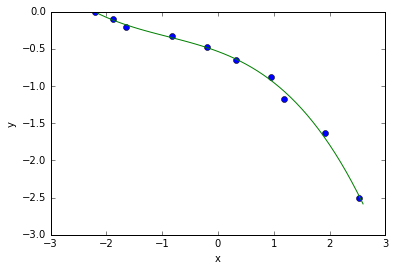

In [14]:
import matplotlib.pyplot as plt

x = [2.53240, 1.91110, 1.18430, 0.95784, 0.33158,
     -0.19506, -0.82144, -1.64770, -1.87450, -2.2010]

y = [-2.50400, -1.62600, -1.17600, -0.87400, -0.64900,
     -0.477000, -0.33400, -0.20600, -0.10100, -0.00600]

coefficients = numpy.polyfit(x, y, 3)
polynomial = numpy.poly1d(coefficients)
xs = numpy.arange(-2.2, 2.6, 0.1)
ys = polynomial(xs)

plt.plot(x, y, 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [15]:
def cubic_fit(data_series):
    """Fit a cubic polynomial to a 1D numpy array."""
    
    x = numpy.arange(0, len(data_series))
        
    coefficients = numpy.polyfit(x, data_series, 3)
    polynomial = numpy.poly1d(coefficients)

    return polynomial(x)


def cubic_fit_ds(dataset):
    """Fit a cubic polynomial to an xarray dataset."""

    return numpy.apply_along_axis(cubic_fit, 0, dataset)

In [16]:
import dask.array as da
#dask_array = da.from_array(rechunked['thetao'], chunks=(1956, 1, 189, 192))
dask_array = rechunked['thetao'].data

In [17]:
print dask_array

dask.array<rechunk..., shape=(1956, 31, 189, 192), dtype=float64, chunksize=(1956, 1, 189, 192)>


In [18]:
cubic_data = dask_array.map_blocks(cubic_fit_ds)

In [19]:
cubic_data.chunks

((1956,),
 (1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1),
 (189,),
 (192,))

In [20]:
cubic_data.shape

(1956, 31, 189, 192)

In [21]:
new_ds = xarray.Dataset({'thetao': (('time', 'lev', 'lat', 'lon',), cubic_data)})

In [22]:
file_nums = range(0,31)
paths = ['/g/data/r87/dbi599/dask_%s.nc' %f for f in file_nums]
xarray.save_mfdataset(new_ds, paths)

ValueError: must supply lists of the same length for the datasets, paths and groups arguments to save_mfdataset

### A simple example

To try and figure out if `save_mfdataset()` accepts dask arrays...

In [49]:
ds_small = xarray.open_mfdataset(infile2) 

In [50]:
print ds_small

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 189, lev: 31, lon: 192, time: 120)
Coordinates:
  * time       (time) datetime64[ns] 1860-01-16T12:00:00 1860-02-15 ...
  * lev        (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat        (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * bnds       (bnds) int64 0 1
Data variables:
    time_bnds  (time, bnds) float64 3.65e+03 3.681e+03 3.681e+03 3.709e+03 ...
    lev_bnds   (lev, bnds) float64 0.0 10.0 10.0 21.62 21.62 35.14 35.14 ...
    lat_bnds   (lat, bnds) float64 -90.0 -87.71 -87.71 -86.77 -86.77 -85.83 ...
    lon_bnds   (lon, bnds) float64 -0.9375 0.9375 0.9375 2.812 2.812 4.688 ...
    thetao     (time, lev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    institution: Australian Commonwealth Scientific and Industrial Research Organization (CSIRO) Marine and Atmospheric Research (Melbourn

In [53]:
type(ds_small['thetao'].data)

dask.array.core.Array

In [54]:
cubic_data_small = ds_small['thetao'].data.map_blocks(cubic_fit_ds)

In [58]:
file_nums = range(0,1)
paths = ['/g/data/r87/dbi599/dask_%s.nc' %f for f in file_nums]
xarray.save_mfdataset([cubic_data_small], paths)

TypeError: DataArray.name or Dataset key must be either a string or None for serialization to netCDF files

How do you write a dask array to a netCDF file??? Perhaps manually convert each chuck to a numpy array / xarray dataArray?

## Reading multiple files with iris

In [2]:
import iris

In [3]:
cube = iris.load_cube([infile1, infile2])

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:794: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:794: UserWarning: Missing CF-netCDF measure variable u'volcello', referenced by netCDF variable u'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


ConstraintMismatchError: failed to merge into a single cube.
  cube.attributes values differ for keys: 'history', 'creation_date', 'tracking_id'

In [7]:
history = []

def edit_attributes(cube, field, filename):
    cube.attributes.pop('creation_date', None)
    cube.attributes.pop('tracking_id', None)
    history.append(cube.attributes['history'])
    cube.attributes.pop('history', None)

In [8]:
cubes = iris.load([infile1, infile2], 'sea_water_potential_temperature', callback=edit_attributes)

In [9]:
print cubes

0: sea_water_potential_temperature / (K) (time: 120; depth: 31; latitude: 189; longitude: 192)
1: sea_water_potential_temperature / (K) (time: 120; depth: 31; latitude: 189; longitude: 192)


In [10]:
#iris.util.unify_time_units(cubes)
cubes = cubes.concatenate_cube()

In [11]:
print cubes

sea_water_potential_temperature / (K) (time: 240; depth: 31; latitude: 189; longitude: 192)
     Dimension coordinates:
          time                             x           -             -               -
          depth                            -           x             -               -
          latitude                         -           -             x               -
          longitude                        -           -             -               x
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_CSIRO-Mk3-6-0_historicalMisc_r0i0p1.nc...
          branch_time: 29200.0
          cmor_version: 2.5.9
          comment: Data is stored on the native ocean T-grid on which the data was generated....
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          experiment: other historical forcing
          experiment_id

In [12]:
print len(history)
print history

2
["2011-05-14T02:26:03Z altered by CMOR: Converted units from 'celsius' to 'K'. 2011-05-14T02:26:03Z altered by CMOR: replaced missing value flag (-7.77778e+06) with standard missing value (1e+20).", "2011-05-14T02:27:05Z altered by CMOR: Converted units from 'celsius' to 'K'. 2011-05-14T02:27:05Z altered by CMOR: replaced missing value flag (-7.77778e+06) with standard missing value (1e+20)."]


In [14]:
for i, x_slice in enumerate(cubes.slices(['time', 'latitude', 'longitude'])):
   print(i, x_slice.shape)

(0, (240, 189, 192))
(1, (240, 189, 192))
(2, (240, 189, 192))
(3, (240, 189, 192))
(4, (240, 189, 192))
(5, (240, 189, 192))
(6, (240, 189, 192))
(7, (240, 189, 192))
(8, (240, 189, 192))
(9, (240, 189, 192))
(10, (240, 189, 192))
(11, (240, 189, 192))
(12, (240, 189, 192))
(13, (240, 189, 192))
(14, (240, 189, 192))
(15, (240, 189, 192))
(16, (240, 189, 192))
(17, (240, 189, 192))
(18, (240, 189, 192))
(19, (240, 189, 192))
(20, (240, 189, 192))
(21, (240, 189, 192))
(22, (240, 189, 192))
(23, (240, 189, 192))
(24, (240, 189, 192))
(25, (240, 189, 192))
(26, (240, 189, 192))
(27, (240, 189, 192))
(28, (240, 189, 192))
(29, (240, 189, 192))
(30, (240, 189, 192))


In [17]:
coord_names = [coord.name() for coord in cubes.coords()]

In [18]:
print coord_names

[u'time', u'depth', u'latitude', u'longitude']


In [20]:
cubes.aux_coords

()

In [29]:
str(cubes.coord('time').units)


'days since 1850-01-01 00:00:00'